In [124]:
import scanpy as sc
from genevector.data import GeneVectorDataset
from genevector.model import GeneVector
from genevector.embedding import GeneEmbedding, CellEmbedding

sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=100, facecolor='white')

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.22.4 scipy==1.8.1 pandas==1.4.3 scikit-learn==1.1.1 statsmodels==0.13.2 python-igraph==0.9.11 pynndescent==0.5.7


# Load Spectrum Data and Embedding

In [115]:
adata = sc.read("spectrum.h5ad")
dataset = GeneVectorDataset(adata)
embed = GeneEmbedding("spectrum.vec", dataset,vector="average")

Loading Expression.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3598707/3598707 [00:32<00:00, 111286.01it/s]


Reindexing Cooc


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8900/8900 [00:00<00:00, 11283.65it/s]


Loading average of 1st and 2nd weights.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 3746586.87it/s]


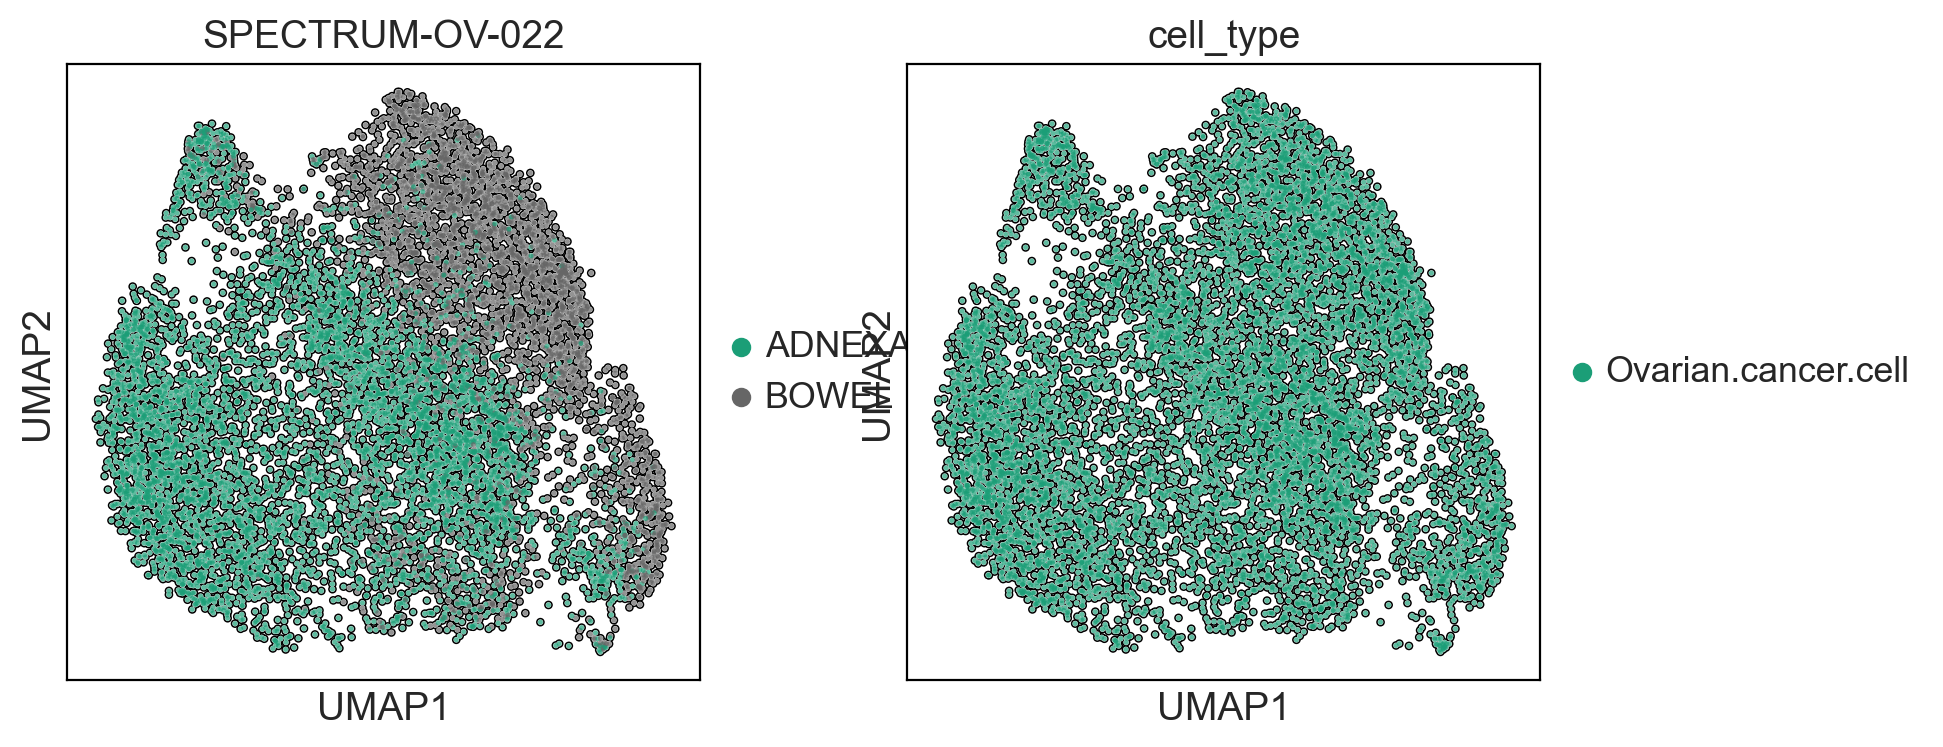

In [126]:
cembed = CellEmbedding(dataset, embed)
adata = cembed.get_adata()

sc.pl.umap(adata,palette="Dark2",color=["Site","cell_type"],
           title=["SPECTRUM-OV-022"],add_outline=True)

# Generate Metagenes

In [117]:
gdata = embed.get_adata(resolution=28.2)
metagenes = embed.get_metagenes(gdata)

In [118]:
%%capture
embed.score_metagenes(adata, metagenes)

# Generate Vectors for each Site

In [119]:
subad = adata[adata.obs["Site"]=="ADNEXA"]
subbo = adata[adata.obs["Site"]=="BOWEL"]

ADNEXA
BOWEL


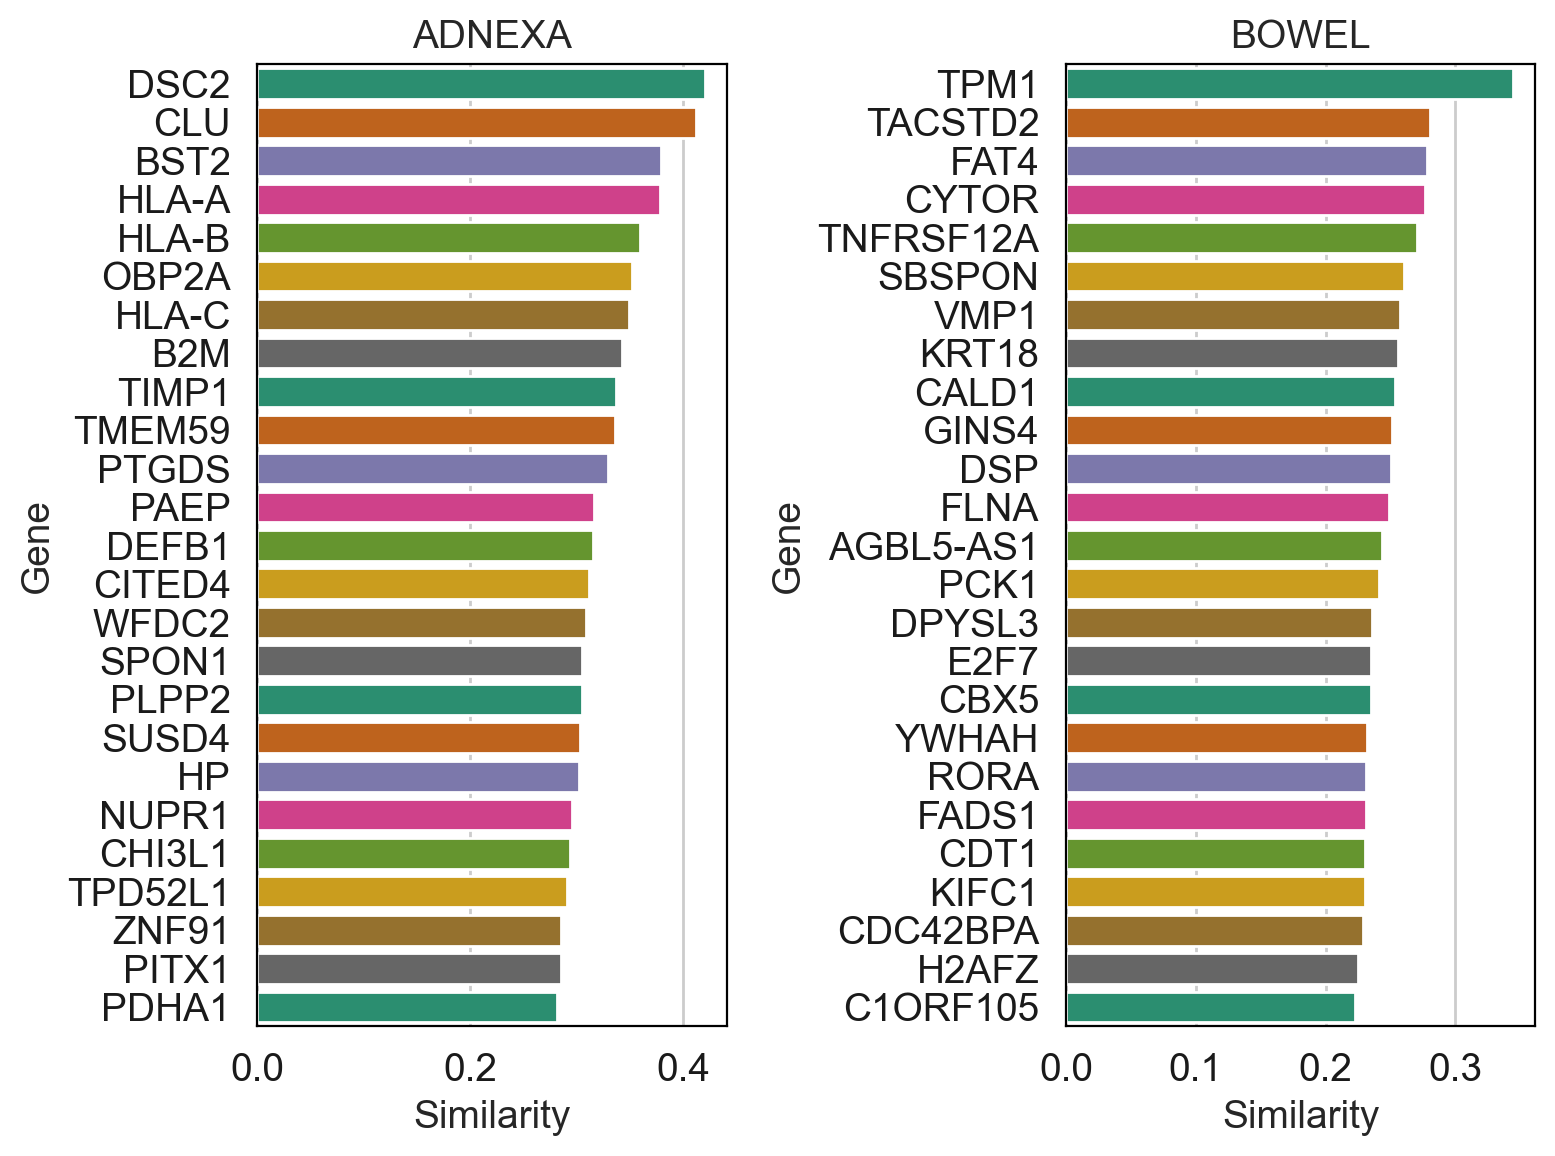

In [127]:
import matplotlib.pyplot as plt
mapped_components = dict(zip(list(cembed.data.keys()),cembed.matrix))
comps = collections.defaultdict(list)
for bc,x in zip(adata.obs.index,adata.obs["Site"]):
    comps[x].append(mapped_components[bc])
vectors = dict()
mean_vecs = []
for x, vec in comps.items():
    print(x)
    ovecs = []
    vec = numpy.mean(vec,axis=0)
    for oph, ovec in comps.items():
        for o in ovec:
            ovecs.append(o)
    aovec = numpy.average(ovecs,axis=0)
    vector = numpy.subtract(vec,aovec)
    vector = numpy.subtract(vector,cembed.dataset_vector)
    vectors[x] = vector
markers = dict()
fig,ax = plt.subplots(1,2,figsize=(8,6))
i = 0
for x, mvec in vectors.items():
    ct_sig = embed.get_similar_genes(mvec)[:25]
    sns.barplot(data=ct_sig,y="Gene",x="Similarity",palette="Dark2",ax=ax[i])
    ax[i].set_title(x)
    i += 1
fig.tight_layout()

# Find Metagenes similar to Adnexa - Bowel (Vector Arithmetic)

In [110]:
from scipy.spatial import distance
res = numpy.subtract(vectors["ADNEXA"],vectors["BOWEL"])
mgs_down = dict()
distances = dict()
for mg, genes in metagenes.items():
    mgvec = embed.generate_vector(genes)
    dist = 1.0 - distance.cosine(res,mgvec)
    distances[mg] = dist
sorted_x = list(reversed(sorted(distances.items(), key=lambda kv: kv[1])))
for mg, dist in sorted_x[:5]:
    print(mg, dist, metagenes[mg])
    mgs_down[mg] = metagenes[mg]

8 0.5387941483786901 ['BST2', 'CHN1', 'CLU', 'HP', 'NPDC1', 'OBP2A', 'PAEP', 'PITX1', 'PORCN', 'PRSS33', 'PTGDS', 'WFDC2']
34 0.5158896865441134 ['DEFB1', 'DSC2', 'IRX3', 'MAL', 'MFGE8', 'PHYHIPL', 'PROM2', 'SUSD4']
4 0.450440954031035 ['B2M', 'GBP1', 'GBP4', 'HLA-A', 'HLA-B', 'HLA-C', 'HLA-E', 'HLA-F', 'IFI27', 'LAP3', 'OPTN', 'PSMB8', 'PSMB9', 'RARRES3', 'TAP1', 'UBE2L6']
103 0.4365971991129275 ['AK4', 'FBLN1', 'HOMER3', 'MLPH', 'PFKP', 'PLPP2']
12 0.3937414246858636 ['ATP6AP2', 'CD63', 'CD81', 'CST3', 'FOLR1', 'KLK11', 'S100A1', 'S100A6', 'SSR4', 'TIMP1', 'TMEM59']


# Find Metagenes similar to Bowel - Adnexa

In [111]:
from scipy.spatial import distance
res = numpy.subtract(vectors["BOWEL"],vectors["ADNEXA"])
mgs_up = dict()
distances = dict()
for mg, genes in metagenes.items():
    mgvec = embed.generate_vector(genes)
    dist = 1.0 - distance.cosine(res,mgvec)
    distances[mg] = dist
sorted_x = list(reversed(sorted(distances.items(), key=lambda kv: kv[1])))
for mg, dist in sorted_x[:5]:
    print(mg, dist, metagenes[mg])
    mgs_up[mg] = metagenes[mg]

16 0.299511793321505 ['ANXA3', 'CALD1', 'CCDC107', 'FLNA', 'MYL9', 'PPFIBP1', 'TAGLN', 'TAGLN2', 'TNFRSF12A', 'TPM1']
9 0.25921517632724955 ['CRABP1', 'EPPK1', 'GOLGA4', 'IGF2BP3', 'LRRFIP2', 'MROH6', 'PLOD2', 'PTPN13', 'RIC3', 'SBSPON', 'SCD', 'SH3RF1']
25 0.25420664364456447 ['ANXA1', 'ANXA2', 'DDAH2', 'KRT18', 'KRT19', 'KRT8', 'LGALS3', 'S100A10']
178 0.25137911022840076 ['AQP3', 'IDH2', 'NKTR', 'TRAM1', 'UACA']
181 0.2513004548264095 ['CMTM6', 'DSP', 'IQGAP1', 'ITGB8', 'YWHAH']


# GSEA Enrichment of Metagenes

/Users/ceglian/miniconda3/lib/python3.9/site-packages/gseapy/enrichr.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.results = self.results.append(res, ignore_index=True)
/Users/ceglian/miniconda3/lib/python3.9/site-packages/gseapy/enrichr.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.results = self.results.append(res, ignore_index=True)
2022-07-25 00:03:29,444 Warning: No enrich terms using library MSigDB_Hallmark_2020 when cutoff = 0.001
/Users/ceglian/miniconda3/lib/python3.9/site-packages/gseapy/enrichr.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.results = self.results.append(res, ignore_index=True)
/Users/ceglian/miniconda3/lib/python3.9/site-packages/gseapy/enrichr.py:427: Future

[[3427.437616324145, 19.659557478207127, 0.0, 0.0, 0.0], [0.0, 0.0, 50.33432963554095, 0.0, 102.57514070844168], [0.0, 49.1849192357055, 0.0, 176.70886404310096, 176.70886404310096], [0.0, 0.0, 36.38152974515558, 0.0, 0.0], [25.93696464958489, 19.659557478207127, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 160.62412864511748, 0.0], [0.0, 54.83034223662069, 98.02820827717792, 0.0, 0.0], [81.11569629500502, 0.0, 0.0, 0.0, 0.0], [25.93696464958489, 0.0, 0.0, 0.0, 74.99696447567176], [0.0, 0.0, 36.38152974515558, 0.0, 0.0], [0.0, 0.0, 0.0, 74.99696447567176, 0.0], [0.0, 0.0, 60.47046101876616, 0.0, 0.0], [0.0, 0.0, 57.0925576041236, 0.0, 0.0], [26.122470758395615, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 36.38152974515558, 0.0, 0.0], [0.0, 0.0, 36.38152974515558, 74.99696447567176, 0.0], [0.0, 0.0, 0.0, 74.99696447567176, 0.0], [35.189808228245795, 0.0, 790.0380265858649, 0.0, 0.0], [0.0, 19.659557478207127, 0.0, 0.0, 0.0], [25.93696464958489, 0.0, 0.0, 0.0, 0.0], [100.4412761916998, 77.73936369017362, 137.708

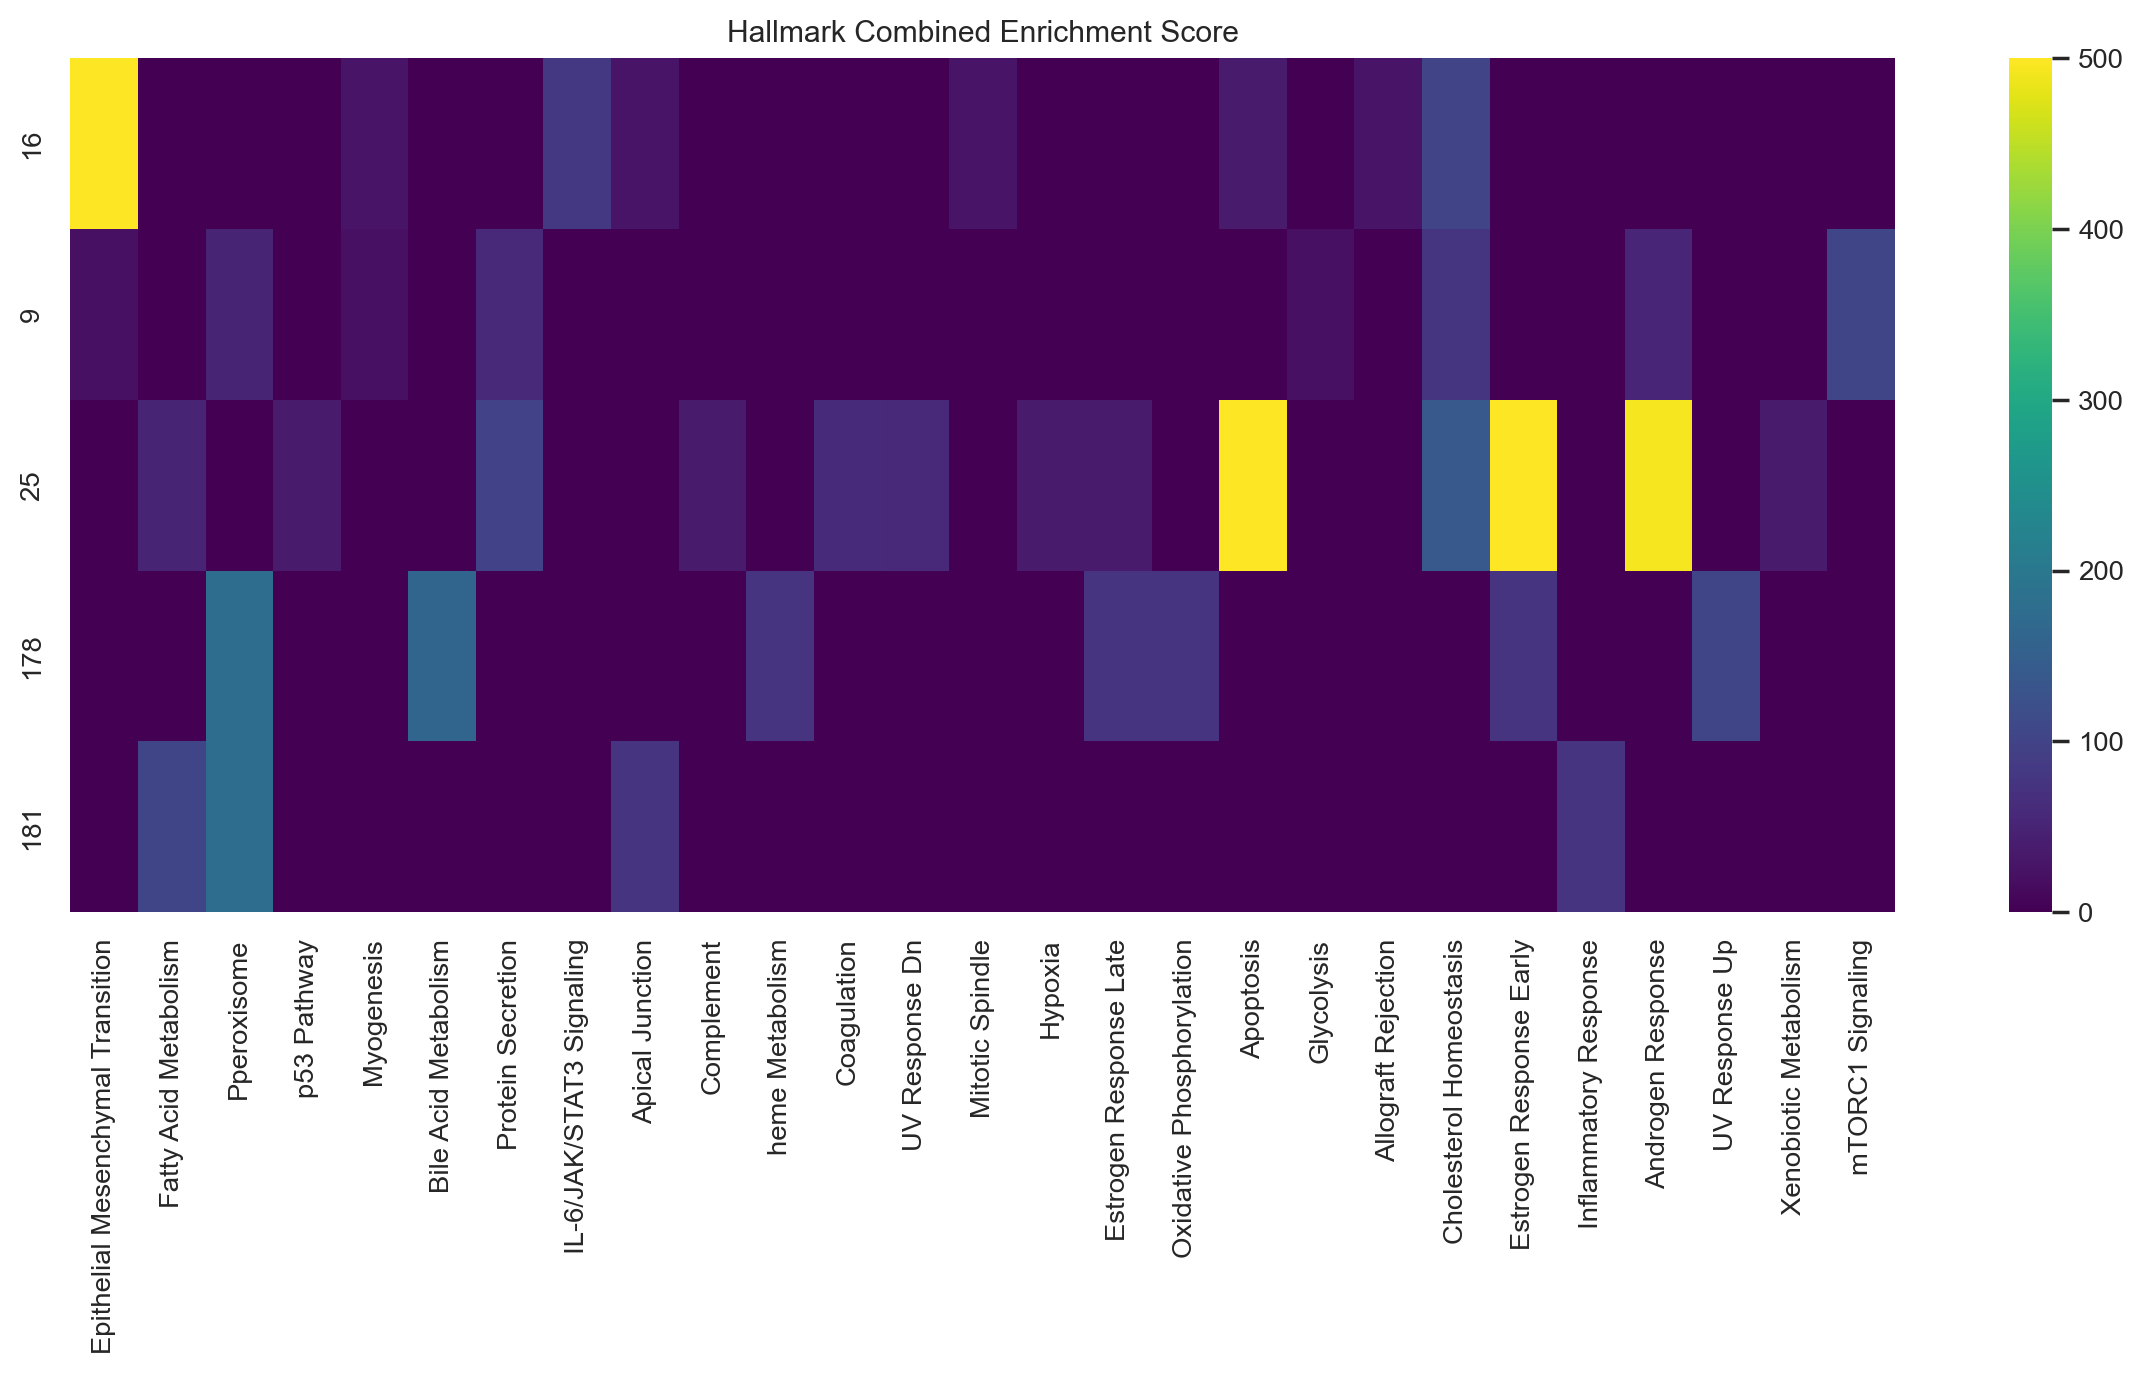

In [128]:
import pandas
sns.set(font_scale=0.9)
import gseapy as gp
enrc = collections.defaultdict(dict)
terms = set()
mgs = []
for mg, genes in mgs_up.items():
    enr = gp.enrichr(gene_list=genes,
                     gene_sets=['MSigDB_Hallmark_2020'],
                     organism='Human', 
                     description='test_name',
                     outdir='test/enrichr_kegg',
                     cutoff=0.001 
                    )    
    mgs.append(mg)
    for x,y in zip(enr.res2d["Term"],enr.res2d["Combined Score"]):
        if y > 0:
            enrc[mg][x] = y
            terms.add(x)
mat = []
for term in terms:
    row = []
    for mg in mgs:
        if term in enrc[mg]:
            row.append(enrc[mg][term])
        else:
            row.append(0.0)
    mat.append(row)
print(mat)
df = pandas.DataFrame(numpy.array(mat),columns=mgs,index=terms).T
fig, ax = plt.subplots(1,1,figsize=(12,7))
sns.heatmap(df,yticklabels=True,xticklabels=True,ax=ax, vmax=500,cmap="viridis")
ax.set_title("Hallmark Combined Enrichment Score")
fig.tight_layout()

/Users/ceglian/miniconda3/lib/python3.9/site-packages/seaborn-0.12.0b2-py3.9.egg/seaborn/matrix.py:1209: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(**tight_params)
/Users/ceglian/miniconda3/lib/python3.9/site-packages/genevector-0.0.1-py3.9.egg/genevector/embedding.py:167: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


<Figure size 500x1300 with 0 Axes>

<Figure size 400x400 with 0 Axes>

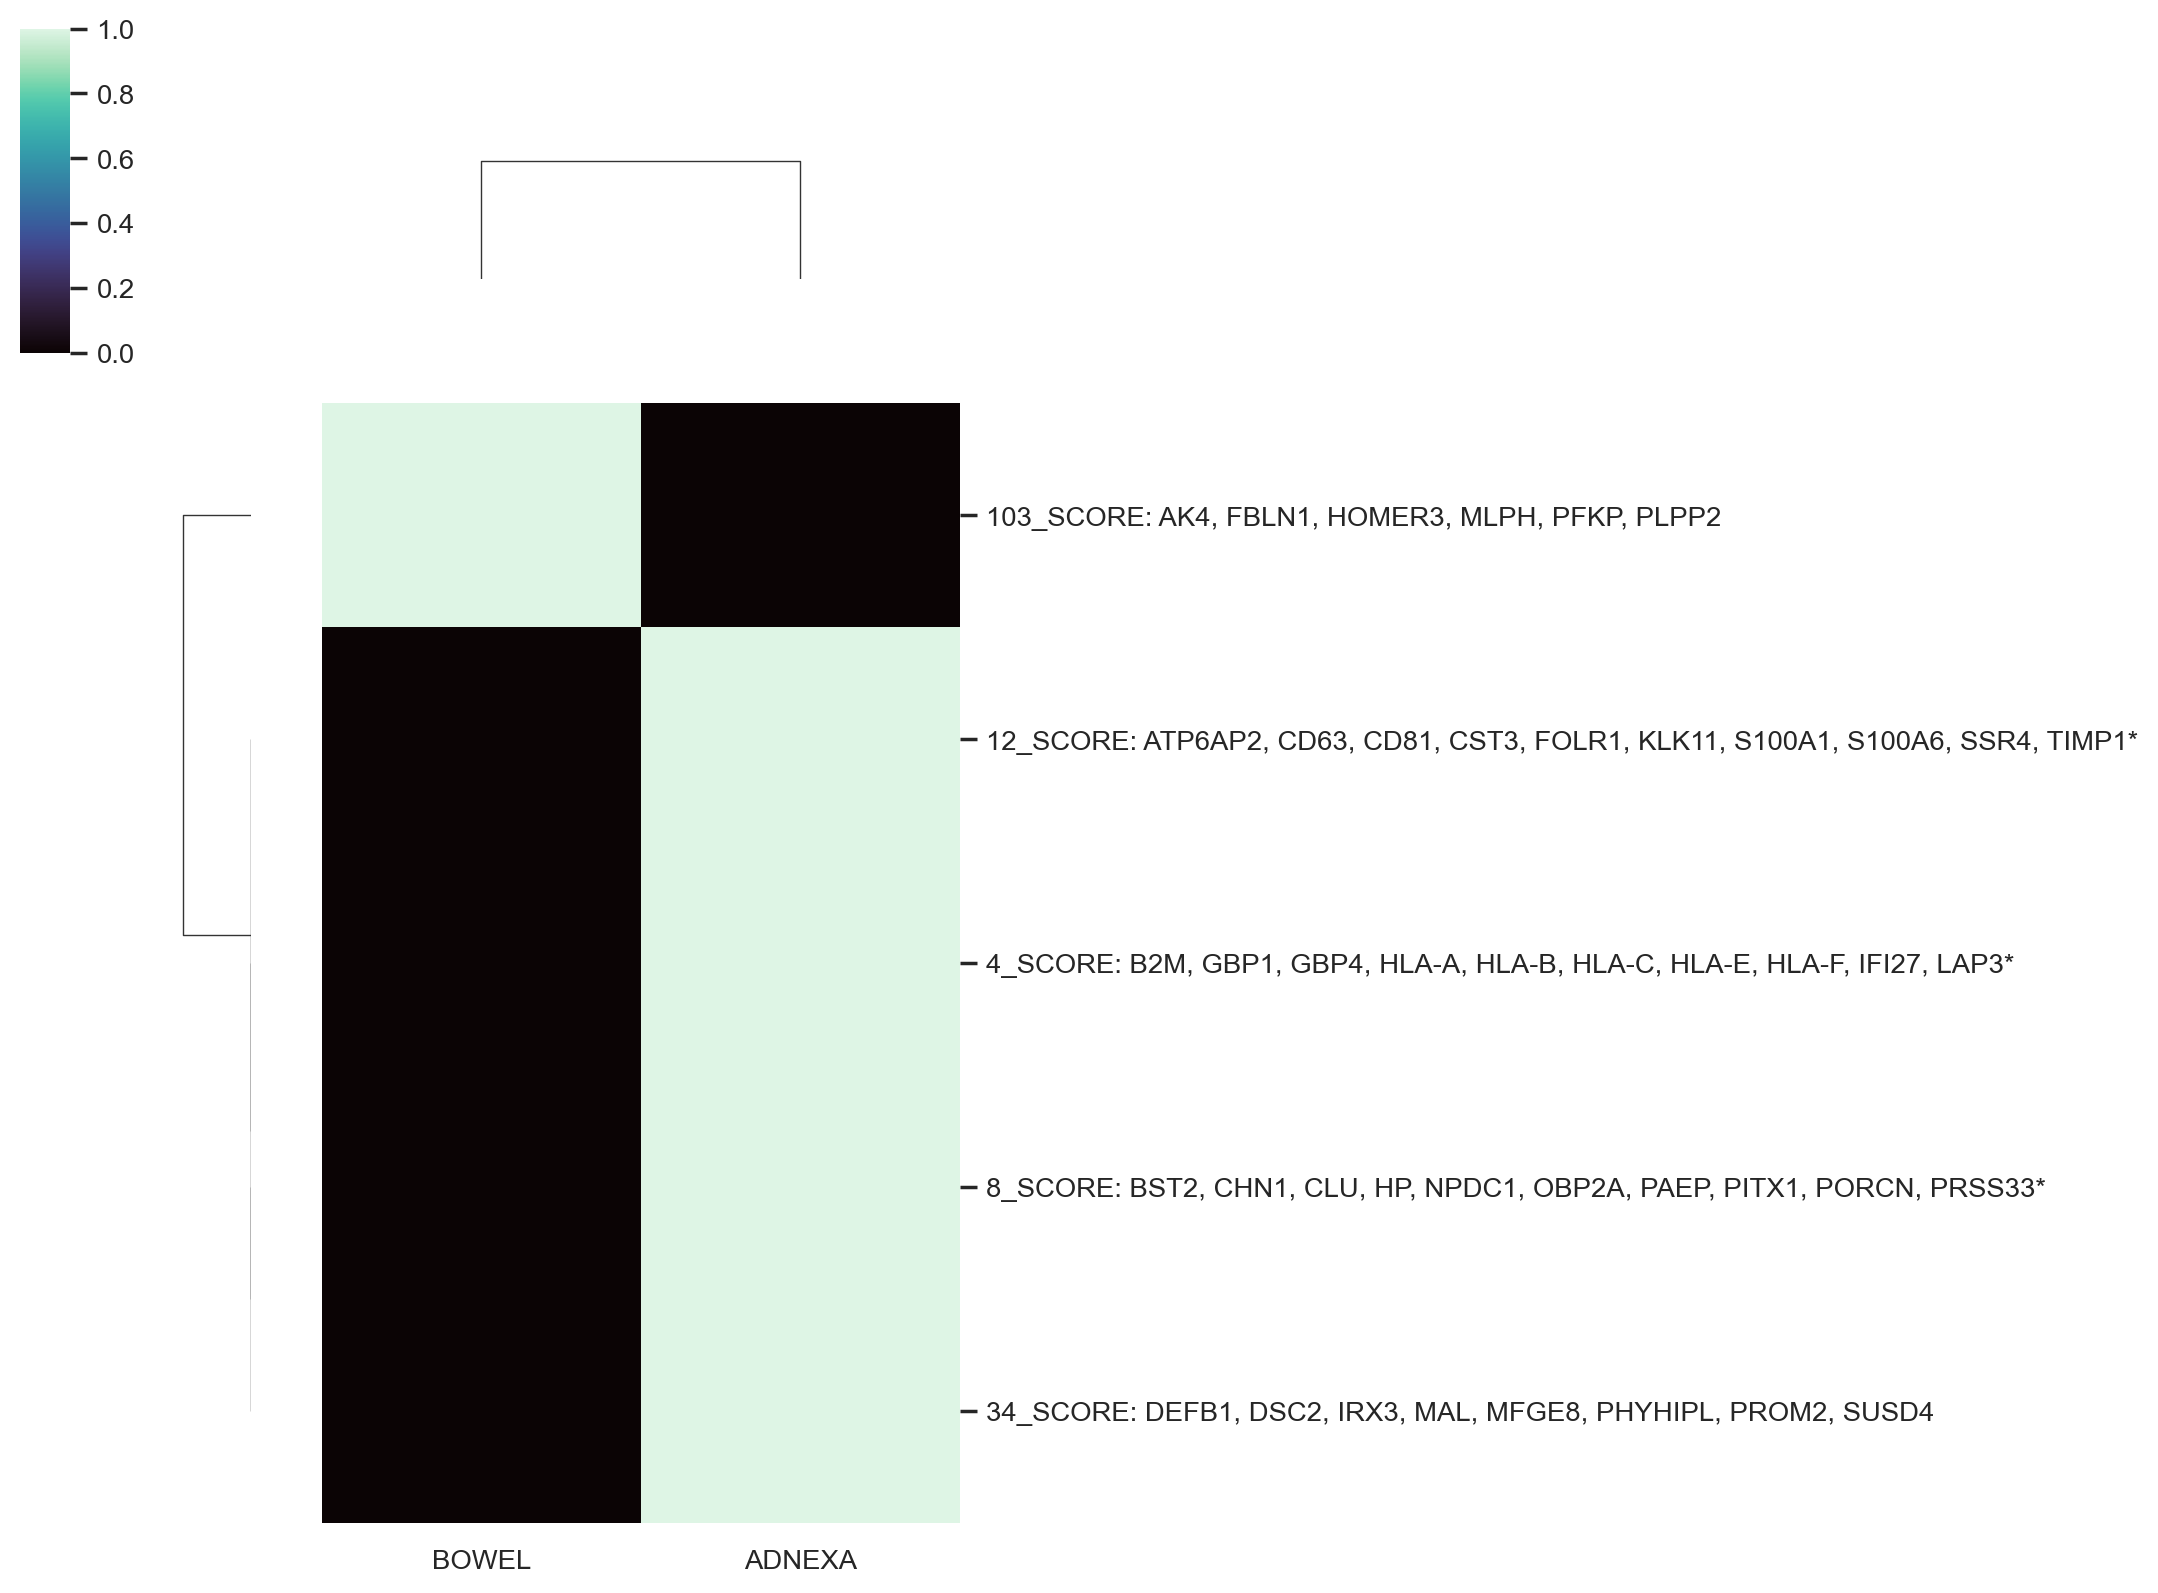

In [129]:
embed.plot_metagenes_scores(adata,mgs_down,column="Site")

/Users/ceglian/miniconda3/lib/python3.9/site-packages/seaborn-0.12.0b2-py3.9.egg/seaborn/matrix.py:1209: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(**tight_params)
/Users/ceglian/miniconda3/lib/python3.9/site-packages/genevector-0.0.1-py3.9.egg/genevector/embedding.py:167: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


<Figure size 500x1300 with 0 Axes>

<Figure size 400x400 with 0 Axes>

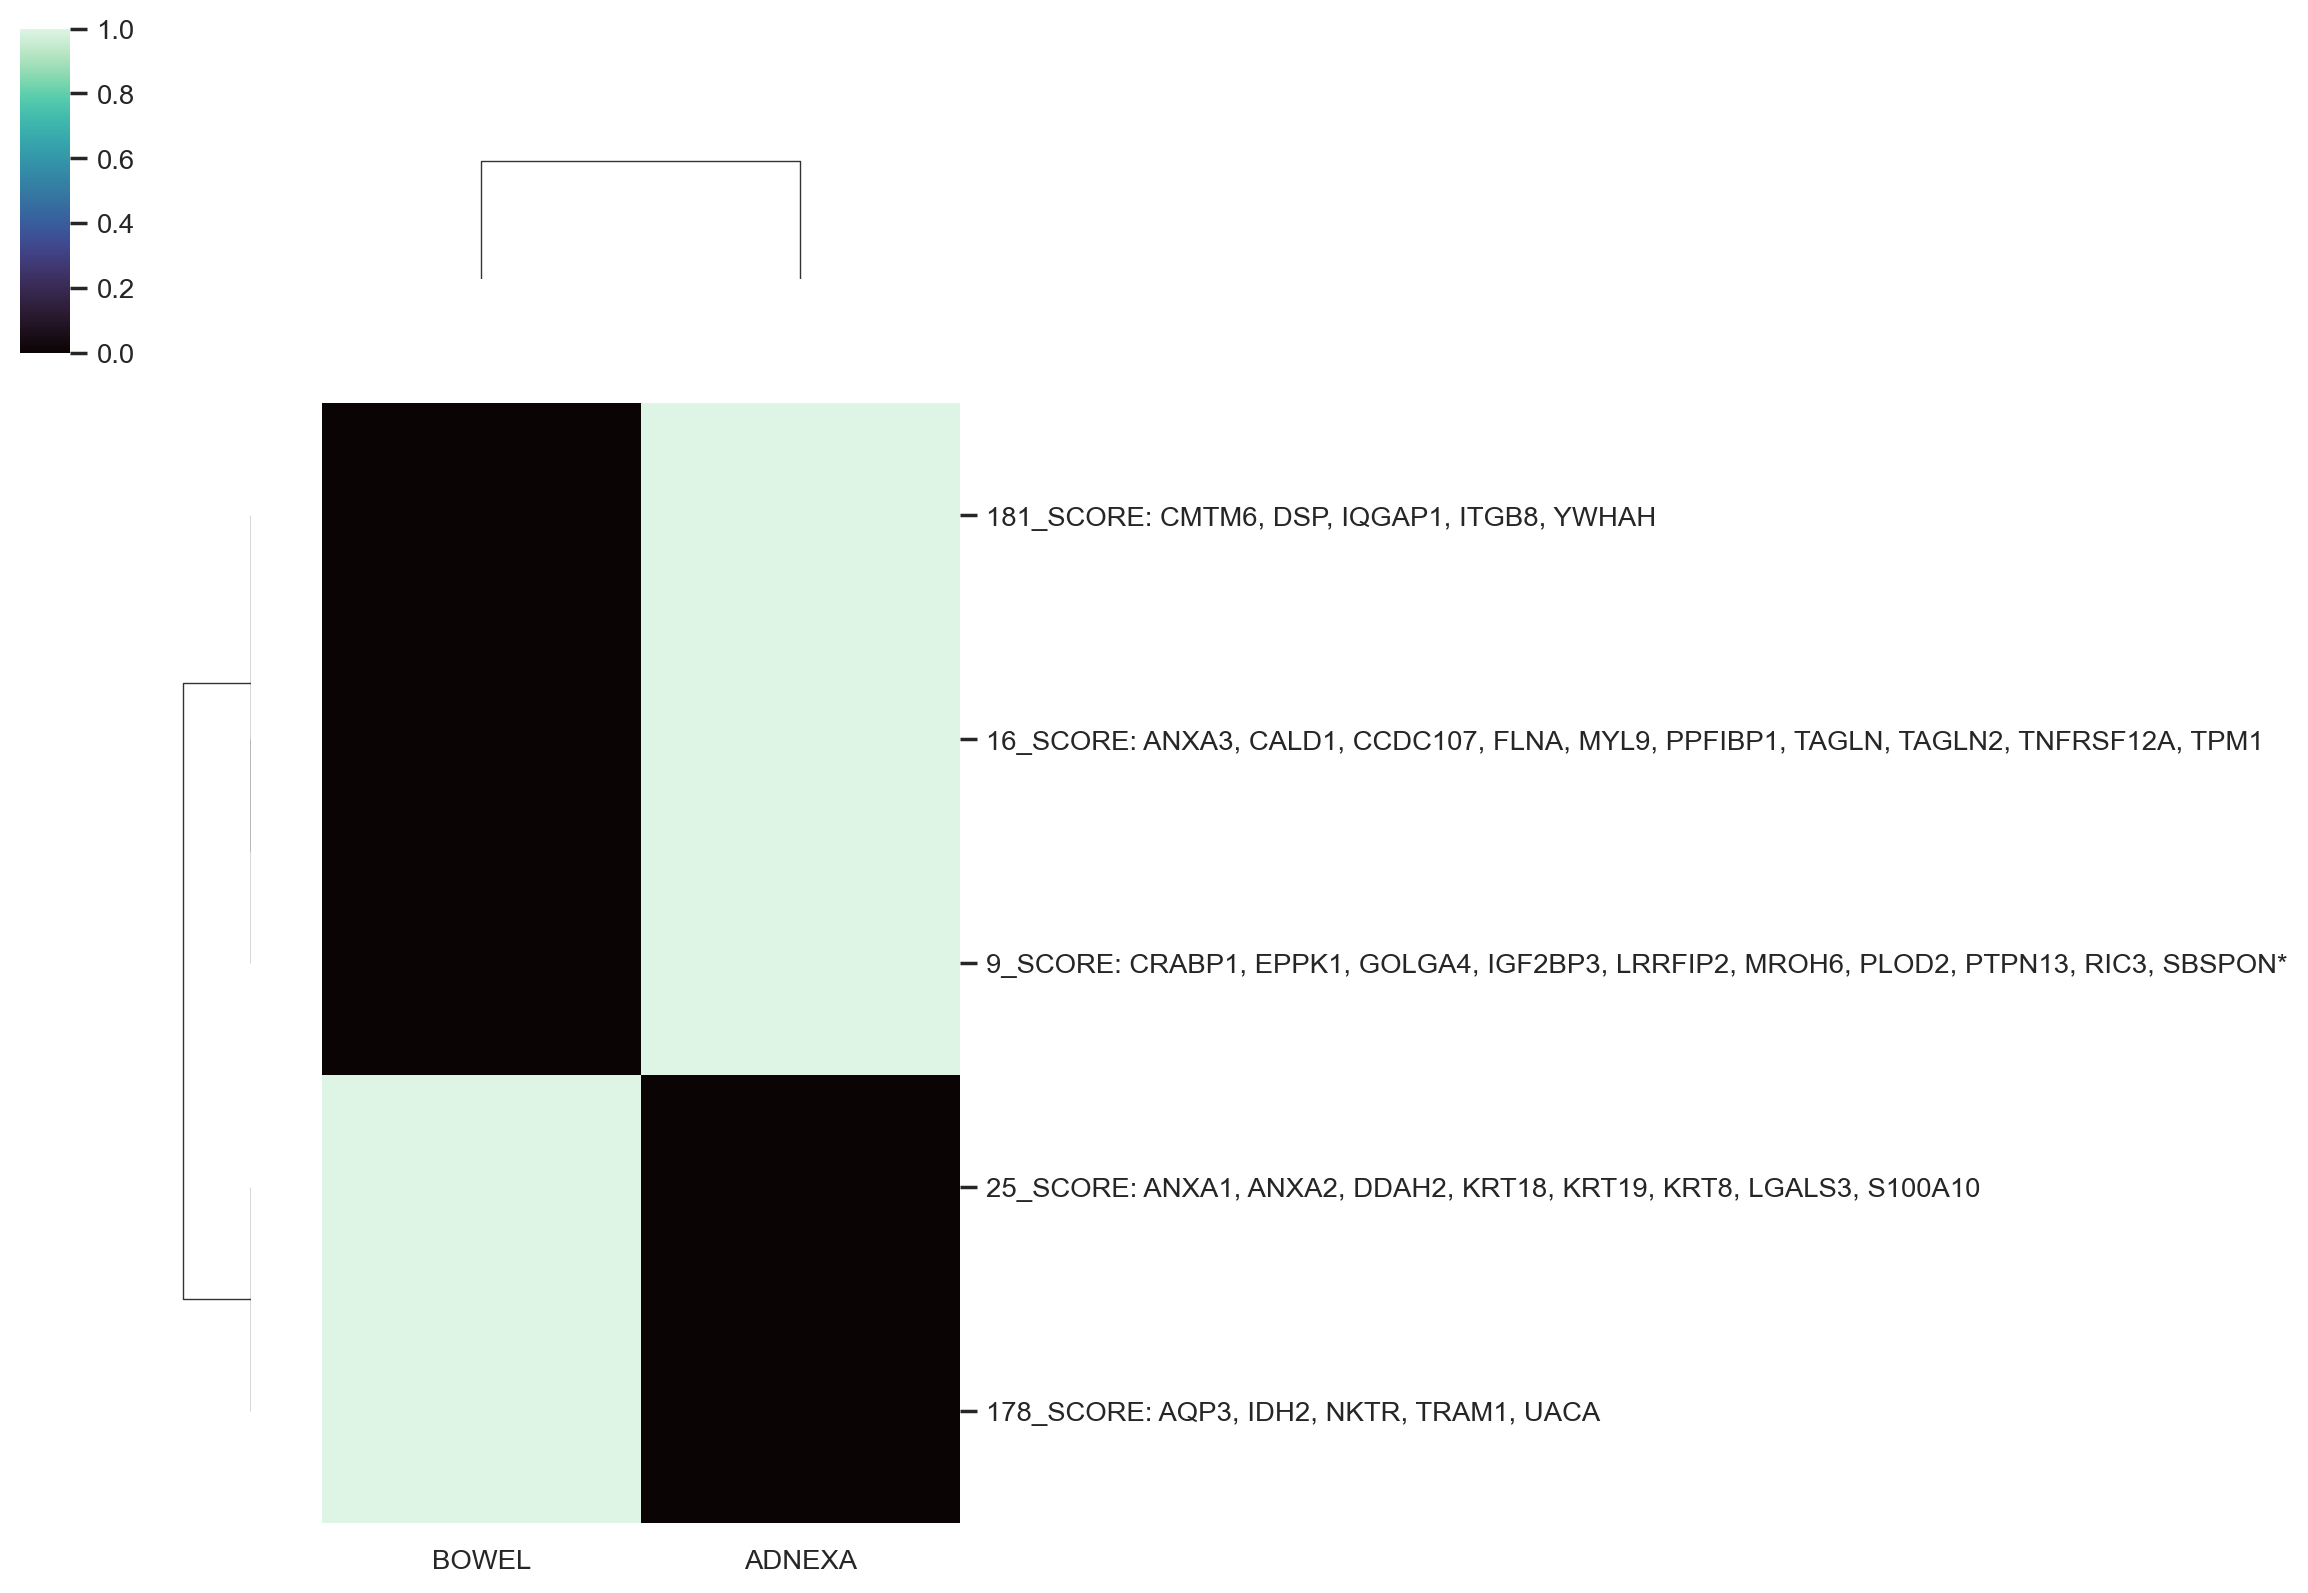

In [130]:
embed.plot_metagenes_scores(adata,mgs_up,column="Site")

# Plot Gene Module Scoring

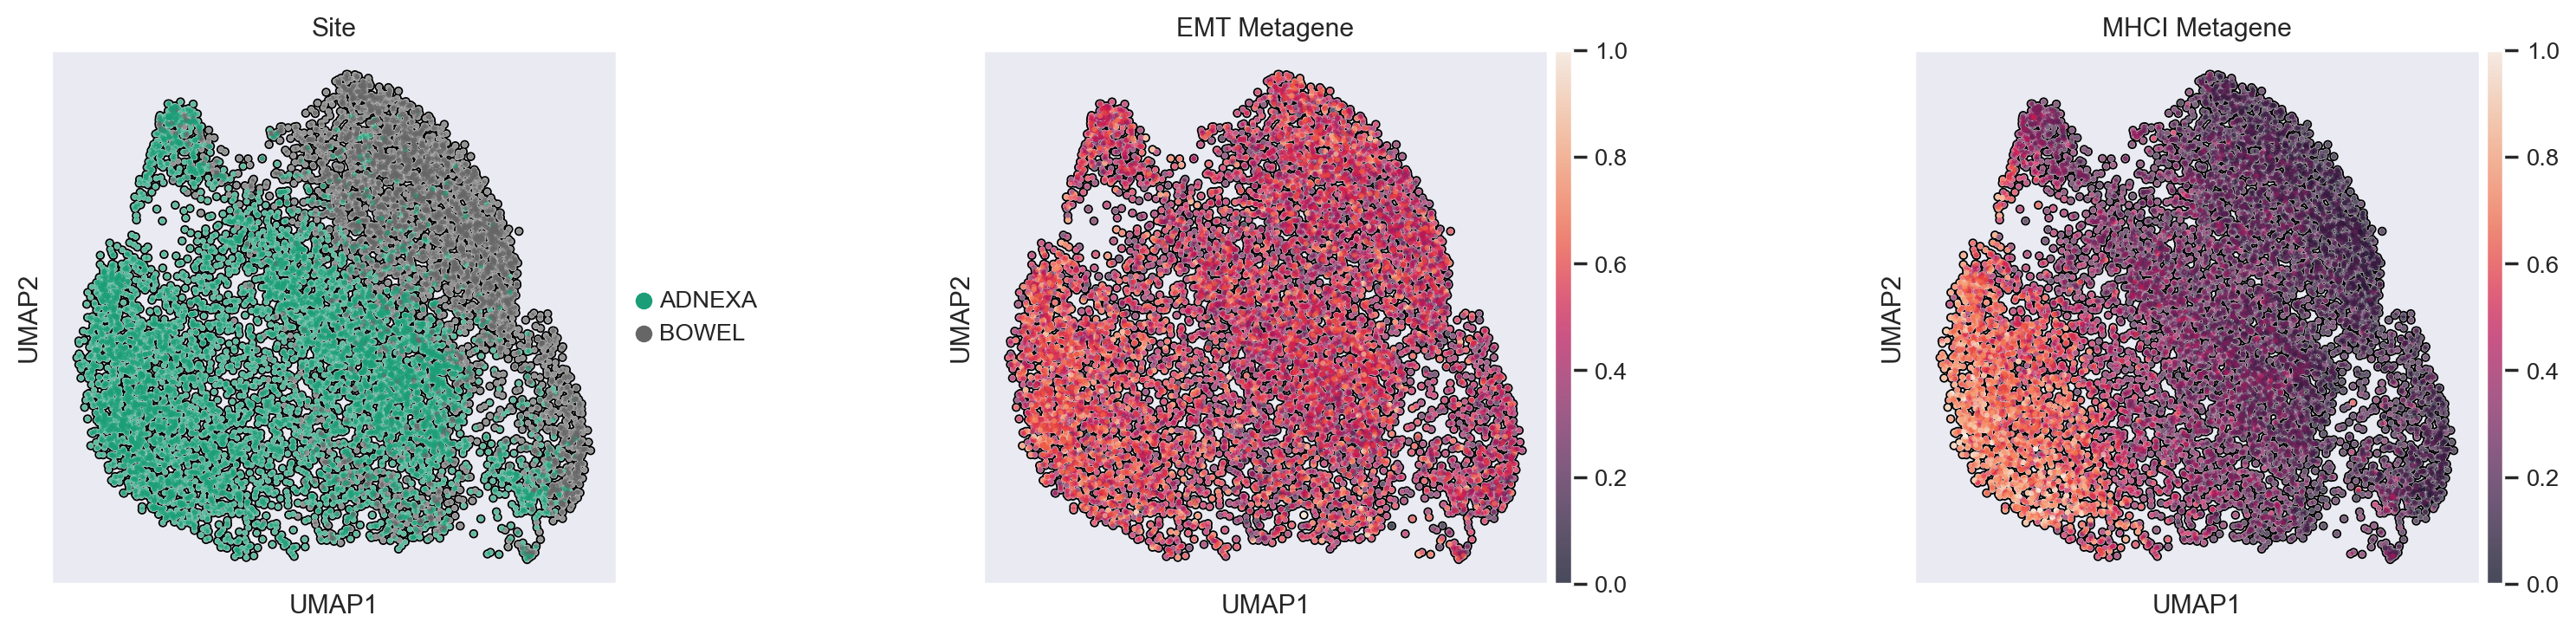

In [132]:
sc.pl.umap(adata,color=["Site","16_SCORE","4_SCORE"],
           title=["Site","EMT Metagene", "MHCI Metagene"],
           size=20,add_outline=True,wspace=0.5)